# PQ算法

## 1.PQ 算法原理分步详解

PQ（**Product Quantization，乘积量化**）是一种**高效的向量压缩与近似距离计算方法**，  
主要应用于大规模向量检索中，用于降低**存储成本**和**计算开销**，同时保持较高的近似精度。

PQ 的核心思想是：  
> **将高维向量拆分为多个子向量，在子空间内进行独立量化，再通过查表法快速计算近似距离。**

下面分步解析 PQ 的原理。

---

### 1.1向量分块（Subspace Division）

1. 假设原始向量为 $x \in \mathbb{R}^D$，例如 $D=128$。  
2. 将其划分为 $m$ 个子向量（子空间）：
   $$
   x = [x_1, x_2, \dots, x_m], \quad x_i \in \mathbb{R}^{D/m}
   $$  
3. 每个子向量在对应的子空间独立处理，减少维度对量化的复杂性。

---

### 1.2子空间量化（Subspace Quantization）

1. 对每个子空间 $x_i$ 构建一个**子码本（Codebook）**：
   使用聚类算法（如 K-Means）将该子空间向量划分为 $k$ 个聚类中心：
    $$
    C_i = \{c_{i,1}, c_{i,2}, \dots, c_{i,k}\}
    $$
2. 将每个子向量 $x_i$ 替换为其最近的聚类中心编号 $q_i$：
   $$
   q_i = \arg\min_j \| x_i - c_{i,j} \|
   $$  
3. 最终，一个高维向量被表示为一组整数索引：
   $$
   x \approx [q_1, q_2, \dots, q_m]
   $$  
✅ 这就是 PQ 的核心压缩方式，将浮点向量转为低位整数索引，大幅节省存储。

---

### 1.3近似距离计算（Approximate Distance Computation）

当有查询向量 $y$ 时：

1. 将查询向量同样划分为 $m$ 个子向量：
   $$
   y = [y_1, y_2, \dots, y_m]
   $$  
2. 对每个子向量 $y_i$ 与对应子码本 $C_i$ 计算**子空间距离表**：
   $$
   D_i[j] = \| y_i - c_{i,j} \|^2, \quad j=1,\dots,k
   $$  
3. 向量 $x$ 与 $y$ 的近似距离可通过查表法快速计算：
   $$
   \|y - x\|^2 \approx \sum_{i=1}^{m} D_i[q_i]
   $$  
- 无需访问原始浮点向量，只需查整数索引对应的距离表；
- 大幅提高计算速度。

---

**PQ 的扩展与优化**

1. **IVF-PQ**  
   - 先使用 IVF 将向量划分簇，再在簇内使用 PQ 进行量化；
   - 兼顾搜索效率和存储压缩。

2. **OPQ（Optimized Product Quantization）**  
   - 在分块前对向量进行旋转/变换，使子空间更加独立，减少量化误差。

3. **PQ + HNSW**  
   - HNSW 用于高精度邻居导航，PQ 用于快速计算局部距离；
   - 适合高维、海量向量场景。


**PQ 的核心优势**

- **高压缩率**：将浮点向量压缩为整数索引，存储占用大幅下降；  
- **高效距离计算**：通过查表法快速估算距离，降低计算量；  
- **可组合性强**：可与 IVF、HNSW 等索引结构结合，实现高效大规模检索；  
- **近似精度可调**：通过调整子向量数 $m$ 和聚类中心数 $k$ 平衡精度与存储。


**类比理解**

PQ 就像把一本厚书拆成若干章节，每章用**章节索引编号**表示：

- 查找书籍时，不用读整本书，只需看章节编号表；
- 最后再定位具体内容，实现快速定位。

这样既节省存储（不存整本书），又加快查找速度（通过索引表）。

## 2.PQ算法实现

🧠 PQ算法Python实现

### 2.1我们导入必要的库：

In [1]:
import numpy as np
from scipy.cluster.vq import kmeans2, vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import time
plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB', 'STHeiti', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
# 设置随机种子以保证结果可重现
np.random.seed(42)

### 2.2实现PQ算法类

In [2]:
class ProductQuantization:
    """乘积量化算法实现"""
    
    def __init__(self, M=8, K=256):
        """
        初始化PQ参数
        
        参数:
        - M: 子空间数量（将向量分割成多少段）
        - K: 每个子空间的聚类中心数量（必须是2的幂次，如256=2^8）
        """
        self.M = M
        self.K = K
        self.codebooks = None  # 码本：存储每个子空间的聚类中心
        self.sub_dim = None    # 每个子空间的维度
        self.is_trained = False
    
    def train(self, vectors, max_iter=100):
        """
        训练PQ码本
        
        参数:
        - vectors: 训练数据，形状为 (n_vectors, dim)
        - max_iter: K-means最大迭代次数
        """
        n_vectors, dim = vectors.shape
        
        # 检查维度是否可被M整除
        if dim % self.M != 0:
            raise ValueError(f"向量维度{dim}不能被M={self.M}整除")
        
        self.sub_dim = dim // self.M
        self.codebooks = np.zeros((self.M, self.K, self.sub_dim), dtype=np.float32)
        
        print(f"开始训练PQ码本: {dim}维向量分割为{self.M}个子空间，每个子空间{self.sub_dim}维")
        print(f"每个子空间使用K={self.K}个聚类中心")
        
        # 对每个子空间分别进行K-means聚类
        for m in range(self.M):
            print(f"训练子空间 {m+1}/{self.M}...")
            
            # 提取当前子空间的数据
            sub_vectors = vectors[:, m*self.sub_dim:(m+1)*self.sub_dim]
            
            # 使用K-means聚类
            # kmeans2返回聚类中心和每个点所属的簇标签
            centroids, labels = kmeans2(sub_vectors, self.K, iter=max_iter, minit='points')
            self.codebooks[m] = centroids.astype(np.float32)
        
        self.is_trained = True
        print("PQ码本训练完成!")
        return self.codebooks
    
    def encode(self, vectors):
        """
        将向量编码为PQ码
        
        参数:
        - vectors: 待编码的向量，形状为 (n_vectors, dim)
        
        返回:
        - codes: PQ编码，形状为 (n_vectors, M)，每个元素是0到K-1的整数
        """
        if not self.is_trained:
            raise ValueError("请先训练PQ码本")
        
        n_vectors = vectors.shape[0]
        codes = np.zeros((n_vectors, self.M), dtype=np.uint8)
        
        for m in range(self.M):
            # 提取当前子空间的向量
            sub_vectors = vectors[:, m*self.sub_dim:(m+1)*self.sub_dim]
            
            # 为每个子向量找到最近的聚类中心
            labels, _ = vq(sub_vectors, self.codebooks[m])
            codes[:, m] = labels
        
        return codes
    
    def decode(self, codes):
        """
        将PQ码解码为近似向量
        
        参数:
        - codes: PQ编码，形状为 (n_vectors, M)
        
        返回:
        - approx_vectors: 近似向量，形状为 (n_vectors, dim)
        """
        if not self.is_trained:
            raise ValueError("请先训练PQ码本")
        
        n_vectors = codes.shape[0]
        dim = self.M * self.sub_dim
        approx_vectors = np.zeros((n_vectors, dim), dtype=np.float32)
        
        for m in range(self.M):
            # 用聚类中心替换编码
            approx_vectors[:, m*self.sub_dim:(m+1)*self.sub_dim] = \
                self.codebooks[m][codes[:, m]]
        
        return approx_vectors
    
    def build_distance_table(self, query):
        """
        构建查询向量的距离表（ADC: Asymmetric Distance Computation）
        
        参数:
        - query: 查询向量，形状为 (dim,)
        
        返回:
        - dist_table: 距离表，形状为 (M, K)
        """
        if not self.is_trained:
            raise ValueError("请先训练PQ码本")
        
        dist_table = np.zeros((self.M, self.K), dtype=np.float32)
        
        for m in range(self.M):
            # 提取查询向量的子向量
            query_sub = query[m*self.sub_dim:(m+1)*self.sub_dim]
            
            # 计算查询子向量到当前子空间所有聚类中心的距离
            dist_table[m] = cdist([query_sub], self.codebooks[m], 'sqeuclidean')[0]
        
        return dist_table
    
    def search(self, query, codes, top_k=5):
        """
        使用PQ进行近似最近邻搜索
        
        参数:
        - query: 查询向量，形状为 (dim,)
        - codes: 数据库向量的PQ编码，形状为 (n_vectors, M)
        - top_k: 返回最相似的top_k个结果
        
        返回:
        - indices: 最近邻的索引
        - distances: 对应的距离
        """
        if not self.is_trained:
            raise ValueError("请先训练PQ码本")
        
        # 构建距离表
        dist_table = self.build_distance_table(query)
        
        n_vectors = codes.shape[0]
        distances = np.zeros(n_vectors, dtype=np.float32)
        
        # 计算每个数据库向量与查询向量的近似距离
        for i in range(n_vectors):
            for m in range(self.M):
                # 累加每个子空间的距离
                distances[i] += dist_table[m, codes[i, m]]
        
        # 返回距离最小的top_k个结果
        indices = np.argsort(distances)[:top_k]
        return indices, distances[indices]
    
    def brute_force_search(self, query, vectors, top_k=5):
        """
        暴力搜索作为基准对比
        """
        distances = cdist([query], vectors, 'sqeuclidean')[0]
        indices = np.argsort(distances)[:top_k]
        return indices, distances[indices]

### 2.3生成示例数据和演示函数

In [3]:
def generate_sample_data(n_samples=1000, dim=128):
    """生成示例数据"""
    # 生成具有聚类结构的数据，更符合真实场景
    np.random.seed(42)
    
    # 创建几个高斯分布的中心点
    centers = [
        np.random.normal(2, 1, dim),
        np.random.normal(-1, 0.5, dim), 
        np.random.normal(0, 1.5, dim),
        np.random.normal(3, 0.8, dim)
    ]
    
    data = []
    for i in range(n_samples):
        center_idx = i % len(centers)
        point = centers[center_idx] + np.random.normal(0, 0.3, dim)
        data.append(point)
    
    return np.array(data, dtype=np.float32)

def demonstrate_pq():
    """完整演示PQ算法"""
    print("=" * 60)
    print("PQ算法演示")
    print("=" * 60)
    
    # 1. 生成数据
    dim = 128
    n_train = 5000
    n_database = 10000
    
    print("生成训练数据...")
    train_vectors = generate_sample_data(n_train, dim)
    database_vectors = generate_sample_data(n_database, dim)
    
    print(f"训练数据: {train_vectors.shape}")
    print(f"数据库数据: {database_vectors.shape}")
    
    # 2. 创建并训练PQ
    pq = ProductQuantization(M=8, K=256)
    
    start_time = time.time()
    pq.train(train_vectors)
    train_time = time.time() - start_time
    print(f"训练耗时: {train_time:.4f}秒")
    
    # 3. 编码数据库向量
    start_time = time.time()
    database_codes = pq.encode(database_vectors)
    encode_time = time.time() - start_time
    
    compression_ratio = (database_vectors.nbytes) / (database_codes.nbytes + pq.codebooks.nbytes)
    print(f"编码耗时: {encode_time:.4f}秒")
    print(f"压缩比: {compression_ratio:.2f}x")
    print(f"原始大小: {database_vectors.nbytes / 1024:.2f} KB")
    print(f"压缩后: {(database_codes.nbytes + pq.codebooks.nbytes) / 1024:.2f} KB")
    
    # 4. 测试搜索
    query = generate_sample_data(1, dim)[0]
    
    # PQ搜索
    start_time = time.time()
    pq_indices, pq_distances = pq.search(query, database_codes, top_k=5)
    pq_time = time.time() - start_time
    
    # 暴力搜索
    start_time = time.time()
    bf_indices, bf_distances = pq.brute_force_search(query, database_vectors, top_k=5)
    bf_time = time.time() - start_time
    
    # 显示结果对比
    print(f"\n搜索结果对比:")
    print(f"PQ搜索    - 找到{len(pq_indices)}个最近邻, 耗时: {pq_time:.6f}秒")
    print(f"暴力搜索 - 找到{len(bf_indices)}个最近邻, 耗时: {bf_time:.6f}秒")
    print(f"速度提升: {bf_time/pq_time:.2f}倍")
    
    print(f"\nPQ结果索引: {pq_indices}")
    print(f"PQ结果距离: {pq_distances}")
    print(f"暴力搜索结果索引: {bf_indices}")
    print(f"暴力搜索结果距离: {bf_distances}")
    
    # 检查召回率
    intersection = set(pq_indices) & set(bf_indices)
    recall = len(intersection) / len(bf_indices)
    print(f"Top-{len(bf_indices)}召回率: {recall:.2%} ({len(intersection)}/{len(bf_indices)})")
    
    return pq, database_vectors, database_codes, query, pq_indices, bf_indices

# 运行演示
pq, vectors, codes, query, pq_results, bf_results = demonstrate_pq()

PQ算法演示
生成训练数据...
训练数据: (5000, 128)
数据库数据: (10000, 128)
开始训练PQ码本: 128维向量分割为8个子空间，每个子空间16维
每个子空间使用K=256个聚类中心
训练子空间 1/8...
训练子空间 2/8...
训练子空间 3/8...
训练子空间 4/8...
训练子空间 5/8...
训练子空间 6/8...
训练子空间 7/8...
训练子空间 8/8...
PQ码本训练完成!
训练耗时: 2.3593秒
编码耗时: 0.0354秒
压缩比: 24.26x
原始大小: 5000.00 KB
压缩后: 206.12 KB

搜索结果对比:
PQ搜索    - 找到5个最近邻, 耗时: 0.032347秒
暴力搜索 - 找到5个最近邻, 耗时: 0.004950秒
速度提升: 0.15倍

PQ结果索引: [   0 1000 4472  512 4080]
PQ结果距离: [ 6.1899347 11.832801  12.133605  12.273722  12.286916 ]
暴力搜索结果索引: [   0 5260 9000 2456 5820]
暴力搜索结果距离: [ 0.         15.6129819  16.08607458 16.3027682  16.46445402]
Top-5召回率: 20.00% (1/5)


### 2.4可视化PQ算法效果

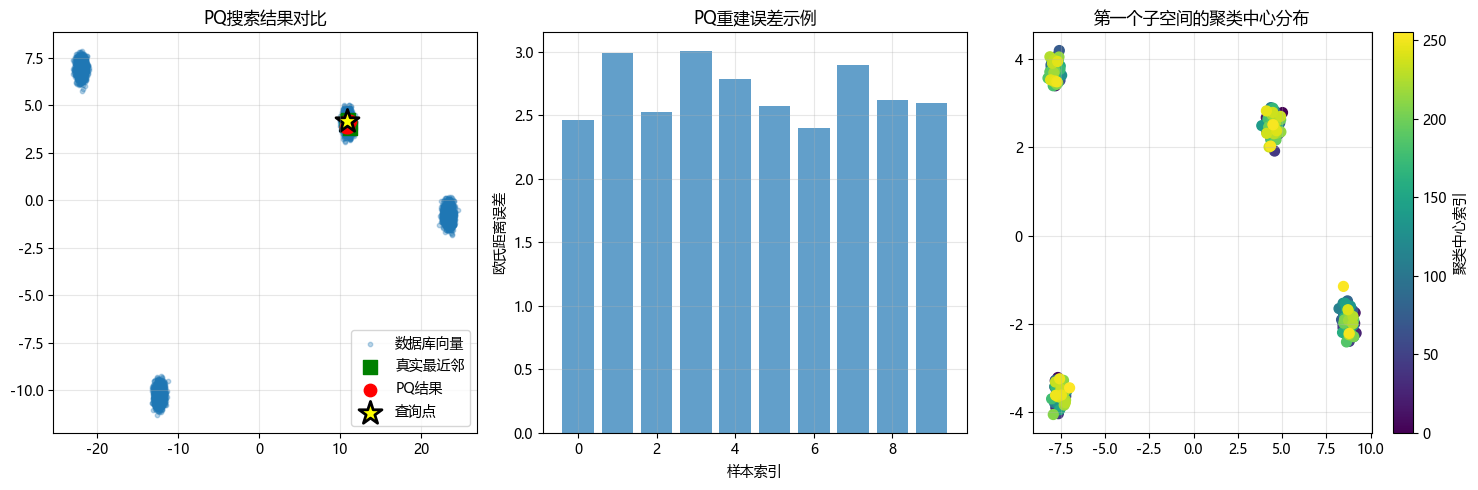

In [4]:
def visualize_pq_effect(pq, vectors, codes, query, pq_results, bf_results):
    """PQ效果可视化函数"""
    from sklearn.decomposition import PCA
    
    # 为码本数据创建独立的PCA模型
    pca_original = PCA(n_components=2)
    
    # 1. 对原始数据进行PCA降维用于可视化
    vectors_2d = pca_original.fit_transform(vectors)
    query_2d = pca_original.transform([query])[0]
    
    plt.figure(figsize=(15, 5))
    
    # 子图1: 显示原始数据分布和搜索结果
    plt.subplot(1, 3, 1)
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.3, s=10, label='数据库向量')
    plt.scatter(vectors_2d[bf_results, 0], vectors_2d[bf_results, 1], 
               c='green', s=100, marker='s', label='真实最近邻')
    plt.scatter(vectors_2d[pq_results, 0], vectors_2d[pq_results, 1], 
               c='red', s=80, marker='o', label='PQ结果')
    plt.scatter(query_2d[0], query_2d[1], c='yellow', marker='*', 
               s=300, edgecolors='black', linewidth=2, label='查询点')
    plt.title('PQ搜索结果对比')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 显示压缩误差（修复后的代码）
    plt.subplot(1, 3, 2)
    
    # 随机选择一些向量显示原始vs重建
    sample_indices = np.random.choice(len(vectors), min(10, len(vectors)), replace=False)
    original_samples = vectors[sample_indices]
    approx_samples = pq.decode(codes[sample_indices])
    
    # 计算重建误差
    errors = np.linalg.norm(original_samples - approx_samples, axis=1)
    
    plt.bar(range(len(errors)), errors, alpha=0.7)
    plt.title('PQ重建误差示例')
    plt.xlabel('样本索引')
    plt.ylabel('欧氏距离误差')
    plt.grid(True, alpha=0.3)
    
    # 子图3: 显示码本分布（修复关键错误）
    plt.subplot(1, 3, 3)
    if pq.codebooks is not None:
        # 将第一个子空间的所有聚类中心展平为2D数据
        sub_vectors = pq.codebooks[0].reshape(-1, pq.codebooks[0].shape[-1])
        
        # 检查数据有效性
        if len(sub_vectors) > 1 and sub_vectors.shape[1] > 0:
            pca_codebook = PCA(n_components=min(2, sub_vectors.shape[1]))
            centroids_2d = pca_codebook.fit_transform(sub_vectors)
            
            plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                       c=range(len(centroids_2d)), cmap='viridis', s=50)
            plt.colorbar(label='聚类中心索引')
            plt.title('第一个子空间的聚类中心分布')
        else:
            plt.text(0.5, 0.5, '码本数据不足或维度为0\n无法进行PCA可视化', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('码本可视化不可用')
        
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 运行可视化
visualize_pq_effect(pq, vectors, codes, query, pq_results, bf_results)

### 2.5参数影响分析

In [5]:
def analyze_pq_parameters():
    """分析PQ参数对性能的影响"""
    dim = 128
    n_data = 5000
    
    data = generate_sample_data(n_data, dim)
    query = generate_sample_data(1, dim)[0]
    
    # 测试不同的参数组合
    param_combinations = [
        {'M': 4, 'K': 64},
        {'M': 8, 'K': 256}, 
        {'M': 16, 'K': 256}
    ]
    
    results = []
    
    for params in param_combinations:
        print(f"\n测试参数: M={params['M']}, K={params['K']}")
        
        pq = ProductQuantization(M=params['M'], K=params['K'])
        
        # 训练
        start_time = time.time()
        pq.train(data)
        train_time = time.time() - start_time
        
        # 编码
        start_time = time.time()
        codes = pq.encode(data)
        encode_time = time.time() - start_time
        
        # 搜索
        start_time = time.time()
        pq_indices, _ = pq.search(query, codes, top_k=5)
        search_time = time.time() - start_time
        
        # 基准测试
        bf_indices, _ = pq.brute_force_search(query, data, top_k=5)
        
        # 计算召回率
        intersection = set(pq_indices) & set(bf_indices)
        recall = len(intersection) / len(bf_indices)
        
        # 计算压缩比
        compression_ratio = data.nbytes / (codes.nbytes + pq.codebooks.nbytes)
        
        results.append({
            'params': params,
            'train_time': train_time,
            'encode_time': encode_time, 
            'search_time': search_time,
            'recall': recall,
            'compression_ratio': compression_ratio
        })
        
        print(f"训练: {train_time:.4f}s, 编码: {encode_time:.4f}s, 搜索: {search_time:.6f}s")
        print(f"召回率: {recall:.2%}, 压缩比: {compression_ratio:.2f}x")
    
    return results

# 运行参数分析
param_results = analyze_pq_parameters()


测试参数: M=4, K=64
开始训练PQ码本: 128维向量分割为4个子空间，每个子空间32维
每个子空间使用K=64个聚类中心
训练子空间 1/4...
训练子空间 2/4...
训练子空间 3/4...
训练子空间 4/4...
PQ码本训练完成!
训练: 0.7320s, 编码: 0.0069s, 搜索: 0.007779s
召回率: 20.00%, 压缩比: 48.51x

测试参数: M=8, K=256
开始训练PQ码本: 128维向量分割为8个子空间，每个子空间16维
每个子空间使用K=256个聚类中心
训练子空间 1/8...
训练子空间 2/8...
训练子空间 3/8...
训练子空间 4/8...
训练子空间 5/8...
训练子空间 6/8...
训练子空间 7/8...
训练子空间 8/8...
PQ码本训练完成!
训练: 2.1279s, 编码: 0.0204s, 搜索: 0.011538s
召回率: 20.00%, 压缩比: 14.96x

测试参数: M=16, K=256
开始训练PQ码本: 128维向量分割为16个子空间，每个子空间8维
每个子空间使用K=256个聚类中心
训练子空间 1/16...
训练子空间 2/16...
训练子空间 3/16...
训练子空间 4/16...
训练子空间 5/16...
训练子空间 6/16...
训练子空间 7/16...
训练子空间 8/16...
训练子空间 9/16...
训练子空间 10/16...
训练子空间 11/16...
训练子空间 12/16...
训练子空间 13/16...
训练子空间 14/16...
训练子空间 15/16...
训练子空间 16/16...
PQ码本训练完成!
训练: 3.8017s, 编码: 0.0430s, 搜索: 0.021575s
召回率: 40.00%, 压缩比: 12.13x


**核心参数的作用与结果分析**

1.子空间数量 (M) 的主导作用

- 从测试结果清晰地展示了 M（子空间数量）是影响PQ算法性能最关键的因素。从组合1到组合3，M从4增加到16，而K在组合2和3中保持不变（256）。这表明性能变化主要由M驱动。

- 召回率提升：当 M从 8 增加到 16 时，召回率从 20% 显著提升到 40%。这是因为将向量分割成更多的子空间（M增大），使得每个子空间的维度更低，量化过程能够更精细地捕捉原始向量的局部特征，从而降低了量化误差，提高了搜索准确性。

- 时间成本增加：然而，更高的 M也带来了明显的代价。训练时间、编码时间和搜索时间都随 M增加而显著上升。这是因为算法需要处理更多的子空间，每个子空间都需要独立的聚类和距离计算，计算复杂度更高。

- 压缩比下降：压缩比从组合1的48.51x下降到组合3的12.13x。虽然绝对值依然可观，但趋势说明M越大，为存储更多子空间的码本所需开销也越大。

2.聚类中心数 (K) 的边际效益

- 对比组合1（K=64）和组合2（K=256），在M同为8的情况下，将K增大4倍，召回率并未改善（均为20%），但训练和搜索时间有所增加。这暗示对于此数据集，在M=8时，单纯增加K可能已无法有效提升量化精度，模型可能受到了其他瓶颈的限制（例如数据分布或M值本身）。

- 组合3实现了最高的召回率，得益于M=16和K=256的配合。但总体40%的召回率说明仍有较大优化空间。

3.整体召回率偏低的原因探析

>  三个参数组合的召回率最高仅为40%，这表明当前量化过程对原始向量信息的损失较大。可能的原因包括：

- 码本训练数据不足：乘积量化需要足够的数据来训练出有代表性的码本。如果训练样本太少或不能代表整体数据分布，量化效果会大打折扣。

- 参数组合仍未达到最优：可能需要尝试M=16搭配更大的K（如512），或者调整其他超参数。

欢迎学习者根据自己对PQ算法的理解对参数或者代码进行优化，进一步挖掘PQ算法的潜力。

以上是全部学习内容，完结。